# Overfitting

We have barely scratched the surface of the big blob of available classification algorithms. There are many variations on kNN and decision trees, as well as algorithms we have not reached. And most learning algorithms have **hyperparameters** that control the complexity and theoretical resolving power of the algorithm. 

:::{note}
In ML, a *parameter* is a value that is adjusted during training; i.e., it is learned from the training data. A *hyperparameter* is one that is selected and remains fixed throughout the training. In most of mathematics, we would refer to these as *variables* and *parameters*, and sources aren't always fastidious about the latter term.
:::

An obvious question about hyperparameters is: Why not just use maximum algorithm power all the time? It's not simply a matter of computing resource limitations, although those can be significant. More importantly, too much resolving power causes a classifier to learn not just major trends, but idiosyncratic details about the training set that may not generalize well, a phenomenon known as **overfitting**.

Consider a kNN classifier with $k=1$. Each training sample's nearest neighbor is itself! Hence this classifier will perfectly fit the training data. Let's apply this to the loan application data, but using many different subsets of the training data in order to simulate what happens in parallel universes. We will use (1 $-$ accuracy) as a measurement of error.

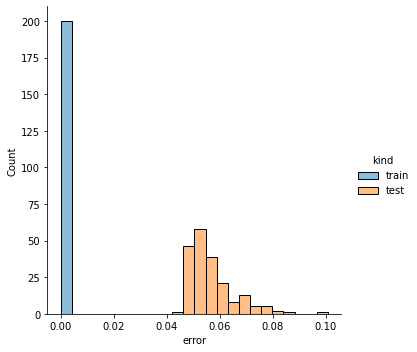

In [1]:
from sklearn import neighbors,metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns

loans = pd.read_csv("loan_clean.csv")
X = loans.drop("percent_funded",axis=1)
y = loans["percent_funded"] > 95
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)

n = 1000             # size of the training subset
err,kind = [],[]     # track information for the results
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for i in range(200):
    X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
    XX,yy = X_tr.loc[:n,:],y_tr.loc[:n]
    knn.fit(XX,yy) 
    err.append(1-knn.score(XX,yy))       # training error
    err.append(1-knn.score(X_te,y_te))   # test error
    kind.extend(["train","test"])

result = pd.DataFrame({"error":err,"kind":kind})
sns.displot(data=result,x="error",hue="kind",bins=24);

As anticipated, the training error (blue histogram) is always zero. But the training error (orange histogram) tells a very different story. 

This is an extreme instance of overfitting. The classifier has perfectly replicated the training data, but it's unable to generalize to new data. That's what causes the wide gap between training and test performance. There is another effect as well: the details of the fit depend strongly on the contents of the training set, so there is a large amount of variance in the testing error. 

If we increase $k$ in the kNN classifier, then each prediction will look at more than one value in the training set, reducing the tendency to overfit.

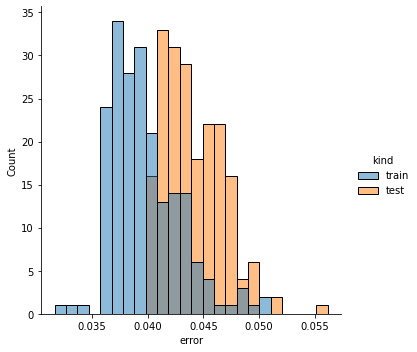

In [2]:
err,kind = [],[]     # track information for the results
knn = neighbors.KNeighborsClassifier(n_neighbors=6)
for i in range(200):
    X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
    XX,yy = X_tr.loc[:n,:],y_tr.loc[:n]
    knn.fit(XX,yy) 
    err.append(1-knn.score(XX,yy))       # training error
    err.append(1-knn.score(X_te,y_te))   # test error
    kind.extend(["train","test"])

result = pd.DataFrame({"error":err,"kind":kind})
sns.displot(data=result,x="error",hue="kind",bins=24);

Now the training error is more comparable to the testing error, and the variance in the testing error is much smaller than before.

## Learning curves

We can illustrate the presence of bias and variance by repeating the parallel-universe experiment of the previous section with different sizes for the training data sets. In order to have more data to pull from, we will use a subset of a realistic data set used to predict the dominant type of tree in patches of forest. We use a decision tree with fixed depth throughout. (Don't confuse the forest for the trees, haha.)

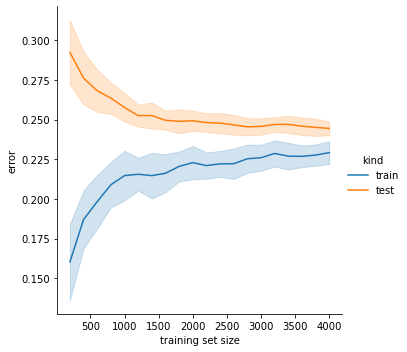

In [3]:
from sklearn import tree
from sklearn import datasets

forest = datasets.fetch_covtype()
X = forest["data"][:250000,:8]
y = forest["target"][:250000]
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.05,shuffle=True,random_state=0)

N = range(200,4001,200)             # size of the training subset
err,kind,length = [],[],[]
dt = tree.DecisionTreeClassifier(max_depth=4) 
for n in N:
    for i in range(50):
        X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
        XX,yy = X_tr[:n,:],y_tr[:n]
        dt.fit(XX,yy)
        err.append(1-dt.score(XX,yy))
        err.append(1-dt.score(X_te,y_te))
        kind.extend(["train","test"])
        length.extend([n,n])

result = pd.DataFrame({"error":err,"kind":kind,"training set size":length})
sns.relplot(data=result,x="training set size",y="error",kind="line",ci="sd",hue="kind");

The plot above shows **learning curves**. The dark line is the mean result over all trials, and the ribbon has a width of one standard deviation. For a small training set, the tree has more than enough resolving power, and we see a great deal of variance in the test error as well as a wide gap between those and the training errors. As the size of the training set grows, the two measurements come together as the variance decreases. 

When you see a large gap between training and test errors, you should suspect that you are in an overfitting regime. Ideally, you could bring more data to the table, perhaps by artificially augmenting the training examples. If not, you might as well decrease the resolving power of your learner, because the excess power is likely to make things worse, not better.

Note that these learning curves start to approach a horizontal asymptote at a nonzero level of error. This level indicates an unavoidable bias for this learner on this data set. As a simple analogy, think about approximating curves in the plane by a parabola. You will be able to do a perfect job for linear and quadratic functions, but if you approximate a cosine curve, you can't get it exactly correct no matter how much information and control you have.